# Homework 3: RNNs

In this assignment, you will use PyTorch and RNNs to solve two NLP problems:

1. Language identification
2. Language modeling

In the first, you will train a classifier to distinguish between English and Spanish sentences, and will essentially be creating a working version of the classifier demonstrated at the end of the PyTorch walkthrough from week 3's lecture. In the second you will train a neural language model to generate new British place names. For the second part, you will find Chapter 17 of the Goldberg text to be a useful reference.

**Note:** The networks that you will be training in this assignment are relatively simple, and the amounts of data are relatively small. That said, _**they will take time to train**_. On my laptop, the various networks take on the order of ≈5 minutes to train. Make sure not to wait until the last minute to do this assignment, as you will need to do a fair bit of experimentation and tinkering, and you won't want to find yourself running out of time.

## Part 0: Setup

In addition to Jupyter and `nose`, you will need to have `pytorch`, `numpy`, `pandas`, and Scikit-Learn installed for this assignment. As in HW2, most of your actual coding will take place in the `hw3_utils` module, and we will use unit tests to verify that things are working appropriately.

In [2]:
import nose
import torch
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sys
from importlib import reload

One other important thing to do is to set the random number generation seed. This will ensure deterministic results: each time you re-run the notebook, you should get the same random numbers. This is vital for ensuring reproducible results.

In [3]:
np.random.seed(42);
torch.manual_seed(42);

As before, let's check and see what versions of the libraries you've got installed:

In [4]:
print("My library versions:")
print(f"PyTorch: {torch.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"nose: {nose.__version__}")
print(f"sklearn: {sklearn.__version__}")

My library versions:
PyTorch: 1.0.1
Pandas: 0.24.1
Numpy: 1.16.1
matplotlib: 3.0.2
nose: 1.3.7
sklearn: 0.20.2


And we can run our tests as before:

In [5]:
! nosetests tests/test_environment.py

.
----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


## Part 1: Preprocessing

### Vocabulary construction

As in the last part of HW2, we will be representing our input as numeric vectors. As such, we need a way to map tokens (characters, in the case of this assignment) to numeric indices. `hw3_utils.vocab` will contain functions to do this sort of transformation. The first such function will be `build_vocab`, and will take as input a corpus of sentences and as output produce mapping dictionaries. `vocab` includes special `BOS_SYM` and `EOS_SYM` symbols, to represent the beginning and end of string, respectively- make sure that the vocabularies that your implementation builds includes these characters.

* **Deliverable 1.1:** Complete the `vocab.build_vocab()` function
* **Test:** `nosetests tests/test_vocab.py:test_d1_1_char_vocab`

_Hint_: Remember that you can split a string into its sequence of characters using the `list` function. For _this_ assignment, you may ignore issues of Unicode decomposition and normalization, but in "real life" you would absolutely need to worry about such things!

In [6]:
from hw3_utils import vocab
reload(vocab);

In [7]:
tiny_corpus = ["This is a sentence.", "This is another sentence.", "Here is a third."]
c2i, i2c = vocab.build_vocab(tiny_corpus)

In [8]:
"T" == i2c[c2i["T"]]

True

In [9]:
!nosetests tests/test_vocab.py:test_d1_1_char_vocab

.
----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


### Sentence representation

In addition to a character inventory, we'll need a way to convert a sentence into a list of indicies. Ordinarily, one would need to worry about how to handle missing vocabulary entries (i.e., OOV words or symbols); _for this assignment_, we are ignoring this problem.

* **Deliverable 1.2:** Complete the `vocab.sentence_to_vector()` function
* **Test:** `nosetests tests/test_vocab.py:test_d1_2_sentence_vector`

In [10]:
reload(vocab);

In [11]:
s = "This is a sentence."
s_vec = vocab.sentence_to_vector(s, c2i)
print(s_vec)

[7, 5, 3, 0, 8, 3, 0, 8, 12, 8, 0, 2, 9, 10, 2, 9, 1, 2, 14]


In [12]:
[i2c[c] for c in s_vec]

['T',
 'h',
 'i',
 's',
 ' ',
 'i',
 's',
 ' ',
 'a',
 ' ',
 's',
 'e',
 'n',
 't',
 'e',
 'n',
 'c',
 'e',
 '.']

PyTorch wants its input as `torch.Tensor` objects, not as Python `list`s, so we'll need to write one more short function to do that conversion. We'll want our tensors to be of size $(1,n)$, where $n$ is the length of the sentence in characters.

* **Deliverable 1.3:** Complete the `sentence_to_tensor()` function
* **Test:** `nosetests tests/test_vocab.py:test_d1_3_sentence_tensor`

In [13]:
reload(vocab);

In [14]:
s = "This is a sentence."
s_tens = vocab.sentence_to_tensor(s, c2i)
print(s_tens)
print(s_tens.size())

tensor([[ 7,  5,  3,  0,  8,  3,  0,  8, 12,  8,  0,  2,  9, 10,  2,  9,  1,  2,
         14]])
torch.Size([1, 19])


### Label lookup table

Just as we need to be able to represent characters as indices, we also need to be able to map _labels_ to indicies. The logic for this is very similar to what we did before for characters, but without the tokenization step.

* **Deliverable 1.4:** Complete the `vocab.build_label_vocab()` function
* **Test:** `nosetests tests/test_vocab.py:test_d1_4_label_vocab`

In [15]:
reload(vocab);

In [16]:
labels = ["eng","eng","spa","eng","deu"]
l2i, i2l = vocab.build_label_vocab(labels)

In [17]:
l2i['spa']

1

In [18]:
i2l[2]

'deu'

In [19]:
[l2i[l] for l in labels]

[0, 0, 1, 0, 2]

## Part 2: Language identification

Language identification is often one of the first steps of an NLP pipeline, and is a foundational task in NLP. _[Automatic Language Identification in Texts: A Survey](https://arxiv.org/pdf/1804.08186.pdf)_, by Jauhiainen et al., gives an excellent overview of the task and its rich history in our field, and I would _strongly_ recommend taking a few minutes to read it before beginning this part of the assignment.

Formally, we can craft language ID as a classification problem, given text sample $x$ and language $l \in L$, we want to find: 

$$ \operatorname*{argmax}_{l} P(l | x ) $$

This can be done in a variety of ways. One common (and well-performing) technique is to use trigram character frequencies, or other character-level features (writing system, etc.); some approaches rely on or incorporate word-level features. The difficulty of the task depends on a number of factors:

* How much training data one has from each language of interest (often an issue)
* How similar the languages are to one another (Spanish and Italian are more difficult to differentiate than are English and Arabic)
* How much ["code-switching"](https://en.wikipedia.org/wiki/Code-switching) is present in the language of interest

The last point is a major one: many texts of interest (tweets, etc.) contain a mix of languages, which can cause trouble both at the time of _training_ a language identification system as well as at the time of _inference_ (i.e., when you're actually trying to _use_ your system). The problem can be compounded by mixed writing systems: due to limitations of text-entry systems, users of some non-Latin scripts often will often write e.g. Arabic using English orthography. Names of places, brands, individuals, etc. can also cause script-level code switching. Fortunately, for this assignment, you will not need to worry about this issue.

We will be using [data](https://tatoeba.org/eng/downloads) from [Tatoeba](https://tatoeba.org), an online crowd-sourced language learning platform. Users collaboratively develop parallel corpora of sentences in a wide variety of languages. For this assignment, I have prepared two data sets based on Tatoeba's data:

* [sentences_bilingual.csv](./data/sentences_bilingual.csv): 10,000 random English and 10,000 random Spanish sentences
* [sentences_multilingual.csv](./data/sentences_multilingual.csv): 10,000 random sentences from each of English, Spanish, German, Italian, and French



## Getting Started

We'll begin with the bilingual (english/spanish) data:

In [20]:
bi_text = pd.read_csv("data/sentences_bilingual.csv")
bi_text.head()

,id,lang,sentence
0,6733426,eng,Tom wasn't able to change anything.
1,256835,eng,I saw the sights of Kyoto during my vacation.
2,1404674,eng,"And where are the aliens, the flying saucers, ..."
3,4833334,eng,Is the water in the Black Sea actually black?
4,7241028,eng,I know a lot of people who don't eat meat.


Step 1 is _always_ to look at your data. Verify how many entries we have, and of what languages:

In [21]:
print(f"Total entries: {len(bi_text)}")

Total entries: 20000


In [22]:
bi_text.groupby('lang').count()

,id,sentence
lang,,
eng,10000,10000
spa,10000,10000


Now, build a character inventory/vocabulary for our data:

In [23]:
c2i, i2c = vocab.build_vocab(bi_text.sentence.values)
l2i, i2l = vocab.build_label_vocab(bi_text.lang.values)

And now let's make a 80/20 training-test split:

In [24]:
from sklearn.model_selection import train_test_split
bi_text_train, bi_text_test = train_test_split(bi_text, test_size=0.2)

What is the resulting class distribution?

In [25]:
bi_text_train.groupby('lang').count()

,id,sentence
lang,,
eng,7981,7981
spa,8019,8019


In [26]:
bi_text_test.groupby('lang').count()

,id,sentence
lang,,
eng,2019,2019
spa,1981,1981


That's close enough to equal to be usable!

## Building a model

You should see that the data set is _balanced_ between two categories, English and Spanish.

The classification model you will build will first project sparse character representations to a dense learned embedding representation (as in Goldberg 4.8), feed the result into an LSTM, and then use the LSTM's output as the input into a softmax classifier to predict the language of the input. Note that we want to use the _final_ LSTM output for classification. More formally:

$$ \hat{y} = \operatorname*{softmax} \mathbf{o}^{(n)} $$

$$ \mathbf{o} = \mathbf{h} \mathbf{W}_o^T + b_o $$

$$ \mathbf{h} = LSTM(\mathbf{x})$$

$$ \mathbf{x}_{1:n} = \mathbf{E}[w_1], ... , \mathbf{E}[w_n] $$

Where $\mathbf{E}$ is an embedding layer, with its own learned weights, etc. We can use PyTorch's [`nn.Embedding`](https://pytorch.org/docs/stable/nn.html#embedding) layer class to take care of this part of our network- it takes as input a character index (just like the ones produced by our vocabulary function above). Similarly, we can use [`nn.LSTM`](https://pytorch.org/docs/stable/nn.html#lstm), [`nn.Linear`](https://pytorch.org/docs/stable/nn.html#linear), and [`nn.LogSoftmax`](https://pytorch.org/docs/stable/nn.html#logsoftmax) to create the rest of the layers.

This architecture has several hyperparameters that you must specify:

0. How many distinct characters do you need to represent ($n$)?
1. How many dimensions to use for embedding (representing) the characters ($e$)?
2. How many dimensions (hidden units) should the LSTM have ($h$)?
3. How many layers should the LSTM have?
3. How many output classes should the network have ($c$)?

The dimensionality of the layers of the network should then be: $n \times e$ for the embedding layer, $e \times h$ for the LSTM, and $h \times c$ for the output layer.

For this part of the assignment, I have done much of the work for you, and have provided a skeleton class with completed initialization functions. 

* **Deliverable 2.1:** Following the MLP example in the PyTorch walkthrough from Week 3, complete the `forward()` method in the `nn.Module` that is started for you in `hw3_utils.lang_id`. 
* **Test:** `nosetests tests/test_lang_id.py:test_d2_1_forward`



_Note_: typically, PyTorch networks are trained using minibatch training (see Goldberg 5.2.8); for the sake of keeping this assignment simple, we will not be using the standard PyTorch batching behaviors. Instead, we will be batching "manually"- calling `.backward()` and updating our parameters after a configurable interval. This will make training take a little bit longer, but will make _your_ code simpler. As such, the shape of the input will be slightly different than PyTorch expects by default. You may need to experiment a bit!

Also note that this is a "many-to-one" RNN architecture. Out of the box, `nn.LSTM` is set up for _many-to-many_ architectures where the input and output are synchronized- in other words, if you feed five time points _in_ to the LSTM (i.e., providing a $(1,5)$ input), you'll get a $(1,5)$ _output_ back. Since we only care about the _last_ timepoint's output for our classification problem, at some point you'll need to extract that value.

In [27]:
from hw3_utils import lang_id

Here, I am initializing the model with 10 embedding dimensions, 20 hidden dimensions, a single LSTM layer, and two output classes (_`eng`_ and _`spa`_):

In [28]:
reload(lang_id);

li = lang_id.LangID(
    input_vocab_n=len(c2i), 
    embedding_dims=10,
    hidden_dims=20,
    lstm_layers=1,
    output_class_n=2
)

Now that it's initialized, I can provide it with input and verify that the output is of the dimensionality I expect:

In [29]:
li(vocab.sentence_to_tensor("this is a sentence", c2i))

tensor([-0.8121, -0.5869], grad_fn=<SelectBackward>)

In [30]:
li(vocab.sentence_to_tensor("this is a sentence", c2i)).shape

torch.Size([2])

**Tip**: I recommend building up the `forward()` method one layer at a time, at each step of the way verifying that the output you are seeing is what you expect.

That output is the raw log-probabilities associated with each class. This is not especially user-friendly, and makes evaluation a bit more difficult than we might care for. 

* **Deliverable 2.2:** Implement the `predict_one()` function in `hw3_utils.lang_id`.
* **Test:** `nosetests tests/test_lang_id.py:test_d2_2_predict_one`

In [31]:
reload(lang_id);

In [32]:
lang_id.predict_one(li, "this is a sentence", c2i, i2l)

'spa'

## Training and evaluating model

Next, we need to train and evaluate the model. I have provided a `train_model()` function to do the training for this model, in `hw3_utils.lang_id`. This part of the assignment features fewer automated tests, and involves a little bit more thinking and writing.

In [33]:
reload(lang_id);

In [ ]:
trained_model = lang_id.train_model(
    model=li, 
    n_epochs=1,
    training_data=bi_text_train,
    c2i=c2i, i2c=i2c,
    l2i=l2i, i2l=i2l
)

0/16000 average per-item loss: 0.005609301850199699


In [ ]:
trained_model(vocab.sentence_to_tensor("this is a sentence", c2i))

In [ ]:
trained_model(vocab.sentence_to_tensor("quien estas", c2i))

Now that we've got a trained model, it's time to evaluate its performance. 

* **Deliverable 2.3:** Complete the `eval_acc()` function in `hw3_utils.lang_id`. Note that PyTorch `Tensor` objects have an `argmax()` function!
* **Test:** `nosetests tests/test_lang_id.py:test_d2_3_eval_acc`

In [ ]:
acc, y_hat = lang_id.eval_acc(trained_model, bi_text_test, c2i, i2c, l2i, i2l)
print(f"Accuracy: {acc}")

And what if we run this on a new, _untrained_ model?

In [ ]:
untrained = lang_id.LangID(
    input_vocab_n=len(c2i), 
    embedding_dims=10,
    hidden_dims=20,
    lstm_layers=1,
    output_class_n=2
)

acc_untrained, y_hat_untrained = lang_id.eval_acc(untrained, bi_text_test, c2i, i2c, l2i, i2l)

print(f"Accuracy: {acc_untrained}")

As expected, an untrained model gets approximately chance performance.

On our trained model, we were able to achieve ≈90% accuracy on held-out test data, which is very high accuracy! Let's investigate our hyperparameter settings: how small can we make our embedding and hidden dimensions before performance suffers?

* **Deliverable 2.4:** Turn both the embedding dimensions and the hidden dimensions _waaaaay_ down, to 2 each, and retrain/re-evaluate the model. Save your evaluation results to a CSV file named "deliverable_2.4.csv" with three columns: the sentence itself, the _true_ label, and the _predicted_ label. Also produce a text file named "deliverable_2.4.txt" containing the observed evaluation accuracy and an explanation of what you observe. Why is the number what it is?

### Extending to multinomial classification

Clearly, a simple LSTM classifier works very well for this binary classification problem, even for very low-dimensional networks. What if we try and do multi-class classification? Our model should, in theory, be adaptable to that case. How sensitive is it to our network dimensionality?

In [48]:
multi_text = pd.read_csv("data/sentences_multilingual.csv")
multi_text_train, multi_text_test = train_test_split(multi_text, test_size=0.2)

multi_text.groupby('lang').count()


,id,sentence
lang,,
deu,10000,10000
eng,10000,10000
fra,10000,10000
ita,10000,10000
spa,10000,10000


In [49]:
multi_text_train.groupby('lang').count()

,id,sentence
lang,,
deu,7994,7994
eng,8024,8024
fra,7949,7949
ita,8012,8012
spa,8021,8021


In [50]:
c2i, i2c = vocab.build_vocab(multi_text.sentence.values)
l2i, i2l = vocab.build_label_vocab(multi_text.lang.values)

In [51]:
multi_class = lang_id.LangID(
    input_vocab_n=len(c2i), 
    embedding_dims=10,
    hidden_dims=20,
    lstm_layers=1,
    output_class_n=5
)

lang_id.train_model(
    model=multi_class, 
    n_epochs=1,
    training_data=multi_text_train,
    c2i=c2i, i2c=i2c,
    l2i=l2i, i2l=i2l
);

print("done")

0/40000 average per-item loss: 0.014599330723285675
1000/40000 average per-item loss: 1.5959402322769165
2000/40000 average per-item loss: 1.6023319959640503
3000/40000 average per-item loss: 1.6038333177566528
4000/40000 average per-item loss: 1.590908408164978
5000/40000 average per-item loss: 1.5808950662612915
6000/40000 average per-item loss: 1.5569266080856323
7000/40000 average per-item loss: 1.5691877603530884
8000/40000 average per-item loss: 1.5350695848464966
9000/40000 average per-item loss: 1.5278592109680176
10000/40000 average per-item loss: 1.4628705978393555
11000/40000 average per-item loss: 1.456663966178894
12000/40000 average per-item loss: 1.3107162714004517
13000/40000 average per-item loss: 1.3391351699829102
14000/40000 average per-item loss: 1.2879527807235718
15000/40000 average per-item loss: 1.2821139097213745
16000/40000 average per-item loss: 1.2367126941680908
17000/40000 average per-item loss: 1.1812931299209595
18000/40000 average per-item loss: 1.2160

Now that it's trained, let's evaluate it as before:

In [52]:
acc_multi, y_hat_multi = lang_id.eval_acc(multi_class, multi_text_test, c2i, i2c, l2i, i2l)

print(f"Accuracy: {acc_multi}")

Accuracy: 0.6954


For 5-way classification, a single accuracy number is less useful than it is for binary classification. Scikit-Learn has some helpful classes for evaluating classifiers:

In [53]:
from sklearn.metrics import classification_report, confusion_matrix

The `classification_report` function will give us a per-class breakdown of our performance:

In [54]:
y_multi = multi_text_test.lang.values
print(classification_report(y_multi, y_hat_multi))

              precision    recall  f1-score   support

         deu       0.82      0.75      0.79      2006
         eng       0.75      0.75      0.75      1976
         fra       0.69      0.78      0.73      2051
         ita       0.61      0.66      0.63      1988
         spa       0.61      0.53      0.57      1979

   micro avg       0.70      0.70      0.70     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.70      0.69     10000



The `confusion_matrix` function will give us a raw confusion matrix; rows are "truth" and columns are "predictions".

In [55]:
cm = confusion_matrix(y_multi, y_hat_multi)
cm

array([[1512,  334,  124,   31,    5],
       [ 272, 1479,  116,   76,   33],
       [  32,   83, 1592,  160,  184],
       [  14,   48,  166, 1313,  447],
       [   5,   40,  298,  578, 1058]], dtype=int64)

The `lang_id` module has a method to make nicer-looking matrices:

In [56]:
reload(lang_id);

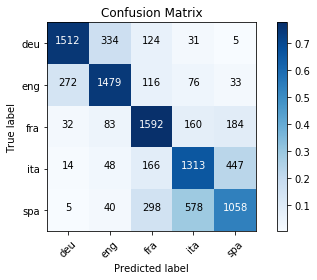

In [57]:
lang_id.pretty_conf_matrix(cm, ['deu','eng','fra','ita','spa'])

* **Deliverable 2.5:** Interpret these results. Why is our classifier performing better on some languages than on others? Put your analysis in a file named `deliverable_2.5.txt`.

From here, the rest of this section is up to you. Experiment with different numbers of embedding & hidden dimensions, hidden LSTM layers, etc., and see how high you can get your classification accuracy. Also try training for additional epochs. Does that help?

* **Deliverable 2.6:** Describe at least two additional models that you trained and evaluated, along with their overall and per-class accuracies. What seemed to help the most? Put your discussion in a file named `deliverable_2.6.txt`.

## Part 3: Language modeling

### Getting Started

In this part of the assignment, you will build and evaluate a simple LSTM character language model, and then _sample_ from it to generate new text mimicking the training data. The model you will build should follow the general structure outlined in Section 17.1 of the Goldberg text, and use the "teacher-forcing" training method outlined in 17.1.1.

$$ p(\mathbf{w}_n | \mathbf{w}_{1:n-1}) = \operatorname*{softmax} \mathbf{o}^{(n-1)} $$

$$ o = \mathbf{h} \mathbf{W}_o^T + b_o $$

$$ \mathbf{h} = LSTM(\mathbf{x})$$

$$ \mathbf{x}_{1:n-1} = \mathbf{E}[w_1], ... , \mathbf{E}[w_n-1] $$

For this part of the assignment, we will be working with a data set of British place names located in `data/towns_clean.txt`.

In [ ]:
corpus = [l.strip() for l in open('data/towns_clean.txt')]
c2i, i2c = vocab.build_vocab(corpus)

for t in np.random.choice(corpus, size=10):
    print(t)

Your network, once trained, will learn to recognize British place names, and will be able to make up new ones.

* **Deliverable 3.1:** Implement the `__init__()`, and `forward()` functions in `hw3_utils.lm.NameGenerator`.
* **Test:** `nosetests tests/test_lm.py:test_d3_1_setup`

Once you've got these methods set up correctly, the following ought to work (in the sense of producing appropriately-sized output):

In [ ]:
from hw3_utils import lm
reload(lm);

In [ ]:
model = lm.NameGenerator(
    input_vocab_size=len(c2i),
    n_embedding_dims=25,
    n_hidden_dims=50,
    n_lstm_layers=1,
    output_vocab_size=len(c2i)
)

x = vocab.sentence_to_tensor("Test input", c2i, True) # make sure to pad w/ bos/eos symbols
y_hat, lstm_hidden_state = model(x, model.init_hidden())
y_hat.shape # should be 1x12x77 (1 x len("Test input")+2 x len(c2i))

Each position $i$ along the second dimension of $\hat{y}$ is the model's estimate of $p(x_{i+1} | x_{1:i})$, and is represented as a multinomial probability distribution in log-space (i.e., each of the 78 possible characters is assigned an estimated log-probability of occurring).

By multiplying across (or summing across, in log-space) each of those values, we can calculate the model's estimate of the probability of an input sequence (see Jurafsky & Martin, Chapter 3 if you need refresher on how this works). As a convenience method, I have provided `lm.compute_prob`.

In [ ]:
lm.compute_prob(model, "Test input", c2i)

In [ ]:
lm.compute_prob(model, "fdsafsadfa", c2i)

This produces _negative log probabilities_. In this case, the model has not yet been trained and so the two sequences are given (very roughly) equivalent probabilities

Note that "out of the box" `compute_prob()` does not _normalize_ the probabilities by sequence length, and as such longer sequences will have lower probabilities on average than shorter sequences, regardless of how plausible they are to the model. If you want to compare the model's estimate of the probabilities of two sequences of different lengths, you must normalize each by the appropriate sequence's length.

Once the model is trained, the estimated probabilities of the two sequences above should be quite different!

### Training

Note that there are two ways to structure the training of this sort of model.

1. One character at a time
2. In a quasi batched manner

The equations above describe character-at-a-time training- starting from the shortest possible prefix of our sequence $\mathbf{w}$, $\mathbf{w}_{1:1}$, and continuing up through successively longer prefixes until reaching $\mathbf{w}_{1:n-1}$, ask the model to predict the next character, accumulating loss with the negative log-likelihood criterion.

In this scenario, if our input training sentence was _"hello there"_, we would perform a series of forward passes:

$x_1="h"$, $y_1="e"$

$x_2="he"$, $y_2="l"$

$x_3="hel"$, $y_3="l"$

... and so forth, either doing a call to `backward()` after each prefix $x_i$ or waiting until the end of the sequence to do so. 

This way works just fine, and is more or less how we will go about sampling from the model, but it is often more efficient to do a more batched training operation. Note that in the above equations, $\mathbf{o}$ will have dimensionality of $(1, n-1, N_{classes})$- in other words, there will be one set of probability estimates for each time point that we have provided the LSTM. PyTorch's `nn.NLLLoss` class can accept input in this shape, and will automatically compute the average loss across the timepoints (and of course will do so a way that keeps the gradients around for correct backpropagation). Training this way can reduce the total number of computations that we need to do in order to train our model.

In this scenario, we would perform a _single_ forward and backward pass, with input that looked like so:

$x="hello\_ther"$, $y="ello\_there"$

Note that PyTorch is perfectly happy either way: the various `nn.*` classes all expect to be able to be given input in this minibatched format. In the first training strategy, the "batch" size is 1; in the second, it is $n-1$ where $n$ is the length of the training example.

The overall process of training this model will be very similar to how we trained the language ID classifier, so use that as a starting point and modify as needed. For starters, train with the following parameters:

* Number of character embedding dimensions: 25
* Number of LSTM hidden units: 50
* Number of LSTM layers: 1

Once your model is trained, you can save it to disk using the `torch.save()` function. This will make it available for the unit test to access.

* **Deliverable 3.2:** Implement the `train()` function in `hw3_utils.lm`. Save a trained model to a file named `deliverable_3.2.mod`.
* **Test:** `nosetests tests/test_lm.py:test_d3_2_training`

In [ ]:
lm.train(model, epochs=2, training_data=corpus, c2i=c2i)

In [ ]:
lm.compute_prob(model, "Test input", c2i)

In [ ]:
lm.compute_prob(model, "fdsafsadfa", c2i)

Remember, this is in log-space, so the difference here is substantial. And now let's try giving it an actual town name as input:

In [ ]:
lm.compute_prob(model, "Wavertree", c2i)

### Sampling

Now that we've got a language model trained, we can sample from it to generate _new_ names. Follow the general procedure outlined in Goldberg 9.5: 

1. Build an initial history consisting of the `vocab.BOS_SYM` symbol
2. Using this history, query the language model, and predict a distribution over next characters
3. Sample a character from that distribution
4. Concatenate the selected character to make a _new_ history
5. Repeat from step 2 until the selected character is `vocab.EOS_SYM` or we hit a maximum length (200 characters, in this assignment).

Once you've implemented sampling, you can generate hilarious and adorable new names!

* **Deliverable 3.3:** Implement the `sample()` function in `hw3_utils.lm`
* **Test:** `nosetests tests/test_lm.py:test_d3_3_sample`

_Hint_: The `torch.multinomial()` function samples from a multinomial distribution stored in a `Tensor`, but _it requires real-space probabilities_, not log-space. `Tensor`s have a `.exp()` method that you may need to use.

In [ ]:
for i in range(10):
    print(lm.sample(model, c2i, i2c))

### Improving your model

These generated names should look more like names of towns than random sequences, but they are a little bit rough compared to the names in the data file. Try modifying your training process to go for additional epochs, and see how that changes your sampled sentences. Also, experiment with different model parameters. What happens if you _decrease_ number of hidden dimensions? What about _increasing_ the dimensionality? How about adding more layers to the LSTM?

One useful thing to try: now that the `sample()` function is written, you might try adding some reporting code to your `train()` function: at regular intervals during training (e.g. every 1000 training examples), you could have it print out a few random towns generated from the model at its current state. This way, you can watch the model evolve over time. How many examples does it need to see before it learns that names always start with upper-case letters?

* **Deliverable 3.4:** Write up a short summary of your observations and investigations into model behavior, including examples, and put it in a text file called `deliverable_3.4.txt`.